## 1.The use of Dataset

In [1]:
import torchaudio
from torch.utils.data import Dataset
import os
import plot_tools
# Download dataset_yesno
yes_no_dataset = torchaudio.datasets.YESNO(root="D:\Coding\Tutorial_DL_Acoustic_Signal\DATA\YESNO_Dataset",download=True)
print("You have downloaded this dataset successfully")

You have downloaded this dataset successfully


In [2]:
# 1. Define own data class
class Mydataset(Dataset):
    def __init__(self, root_dir, label_dir):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.path = os.path.join(self.root_dir, self.label_dir)
        self.audiofile = os.listdir(self.path)
    def __getitem__(self, index):
        audio_name = self.audiofile[index]
        wave_path = os.path.join(self.path, audio_name)
        waveform, sr = torchaudio.load(wave_path)
        return waveform, sr, audio_name
    def __len__(self):
        return len(self.audiofile)



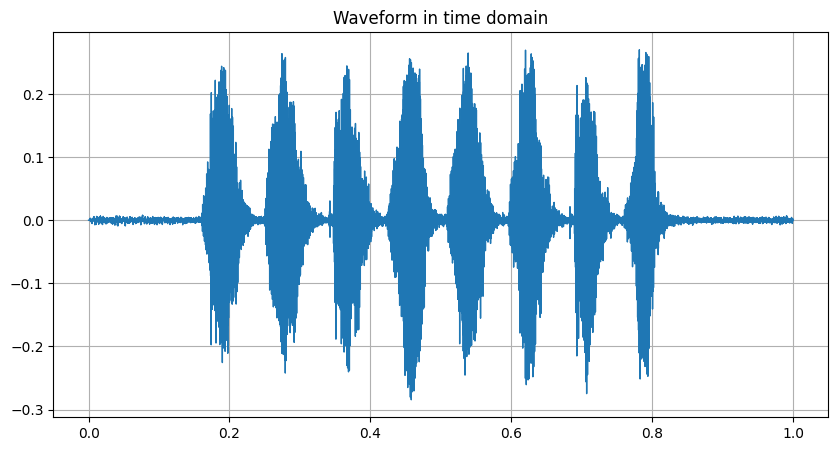

In [3]:
root_dir = r"D:\Coding\Tutorial_DL_Acoustic_Signal\DATA\YESNO_Dataset"
label_dir = "waves_yesno" 
index = 3;
mydata = Mydataset(root_dir = root_dir, label_dir=label_dir)
waveform, sr, name = mydata[index]
plot_tools.plot_waveform_td(waveform=waveform[-1],sr=sr)


## 2. The use of Urbansound 8k

In [4]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class UrbanSound8k(Dataset):
    def __init__(self, root_dir, excel_dir, transforms, target_samples, target_sr) -> None:
        super().__init__()
        self.root_dir = root_dir
        self.excel = pd.read_csv(excel_dir)
        self.transforms = transforms
        self.target_samples = target_samples
        self.target_sr = target_sr
    
    def reshape_if_necessary(self, waveform):
        if waveform.shape[1] > self.target_samples:
            waveform = waveform[:,0:self.target_samples]
        elif waveform.shape[1] < self.target_samples:
            num_pad = len(self.target_samples) - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, pad=(0, num_pad))
        return waveform
    
    def resample_if_necessary(self,waveform,sr):
        if sr != self.target_sr:
            waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=self.target_sr)
        return waveform
    
    def mix_if_necessary(self, waveform):
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        return waveform

    def __getitem__(self, index):
        fold = f"fold{self.excel.iloc[index, 5]}"
        audio_name = f"{self.excel.iloc[index, 0]}"
        target = self.excel.iloc[index, 6]  # 确保这是正确的列索引
        audio_path = os.path.join(self.root_dir, fold)
        audio_files = os.listdir(audio_path)  # 应该是一个局部变量
        wave_path = os.path.join(audio_path, audio_name)
        waveform, sr = torchaudio.load(wave_path)
        waveform = self.reshape_if_necessary(waveform)
        waveform = self.resample_if_necessary(waveform,sr)
        waveform = self.mix_if_necessary(waveform)

        waveform_mel = self.transforms(waveform)
        return waveform_mel, sr, target
    def __len__(self):
        return len(self.audio_file)

c:\Users\admin\.conda\envs\pytorch\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


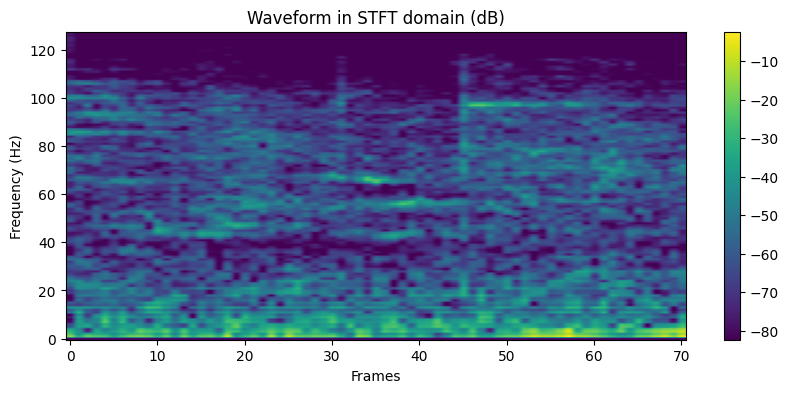

2


In [5]:
root_dir = r"D:\Coding\Tutorial_DL_Acoustic_Signal\DATA\UrbanSound8K\UrbanSound8K\audio"
excel_dir = r"D:\Coding\Tutorial_DL_Acoustic_Signal\DATA\UrbanSound8K\UrbanSound8K\metadata\UrbanSound8K.csv"
trans_mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=512)
mydata = UrbanSound8k(root_dir=root_dir, excel_dir=excel_dir,transforms=trans_mel, target_sr=16000,target_samples=50000)
index = 5
waveform_mel, sample_rate, target = mydata[index]
plot_tools.plot_waveform_stft(waveform_mel[0,:,:])
print(target)

## 3. The use of DataLoader

In [6]:
import torchaudio
import os
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional

In [7]:
# 0.Define Dataset class
class MyData(Dataset):
    def __init__(self, root_dir, label_dir,target_samples,target_sr):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.path = os.path.join(self.root_dir,self.label_dir)
        self.audio_file = os.listdir(self.path)
        self.target_sr = target_sr
        self.target_samples = target_samples

    def reshape_if_necessary(self,waveform):
        if waveform.shape[1] > self.target_samples:
            waveform = waveform[:,0:self.target_samples]
        elif waveform.shape[1] < self.target_samples:
            pad_num = self.target_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform,(0,pad_num))
        return waveform
    
    def resample_if_necessary(self,waveform,sr):
        if sr != self.target_sr:
            waveform = torchaudio.functional.resample(waveform,orig_freq=sr, new_freq=self.target_sr)
        return waveform
    
    def mix_if_necessary(self,waveform):
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform,dim=0,keepdim=True)
        return waveform

    def __getitem__(self,index):
        audio_name = self.audio_file[index]
        audio_path = os.path.join(self.path,audio_name)
        audio,sr = torchaudio.load(audio_path)
        audio = self.reshape_if_necessary(audio)
        audio = self.resample_if_necessary(audio,sr)
        audio = self.mix_if_necessary(audio)

        return audio,audio_name
    
    def __len__(self):
        return len(self.audio_file)

In [8]:
# 2.set the batch_size and load dataset
root_dir = "D:\Coding\Tutorial_DL_Acoustic_Signal\DATA\YESNO_Dataset"
label_dir = "waves_yesno"
mydataset = MyData(root_dir=root_dir,label_dir=label_dir,target_sr=8000,target_samples=20000)
data_batch = DataLoader(dataset=mydataset,batch_size=10,shuffle=False, drop_last=False)
iteration = 0
for data in data_batch:
    waveform, name = data
    iteration += 1
    print(f"the {iteration}th and name is {name}")


the 1th and name is ('0_0_0_0_1_1_1_1.wav', '0_0_0_1_0_0_0_1.wav', '0_0_0_1_0_1_1_0.wav', '0_0_1_0_0_0_1_0.wav', '0_0_1_0_0_1_1_0.wav', '0_0_1_0_0_1_1_1.wav', '0_0_1_0_1_0_0_0.wav', '0_0_1_0_1_0_0_1.wav', '0_0_1_0_1_0_1_1.wav', '0_0_1_1_0_0_0_1.wav')
the 2th and name is ('0_0_1_1_0_1_0_0.wav', '0_0_1_1_0_1_1_0.wav', '0_0_1_1_0_1_1_1.wav', '0_0_1_1_1_0_0_0.wav', '0_0_1_1_1_0_0_1.wav', '0_0_1_1_1_1_0_0.wav', '0_0_1_1_1_1_1_0.wav', '0_1_0_0_0_1_0_0.wav', '0_1_0_0_0_1_1_0.wav', '0_1_0_0_1_0_1_0.wav')
the 3th and name is ('0_1_0_0_1_0_1_1.wav', '0_1_0_1_0_0_0_0.wav', '0_1_0_1_1_0_1_0.wav', '0_1_0_1_1_1_0_0.wav', '0_1_1_0_0_1_1_0.wav', '0_1_1_0_0_1_1_1.wav', '0_1_1_1_0_0_0_0.wav', '0_1_1_1_0_0_1_0.wav', '0_1_1_1_0_1_0_1.wav', '0_1_1_1_1_0_1_0.wav')
the 4th and name is ('0_1_1_1_1_1_1_1.wav', '1_0_0_0_0_0_0_0.wav', '1_0_0_0_0_0_0_1.wav', '1_0_0_0_0_0_1_1.wav', '1_0_0_0_1_0_0_1.wav', '1_0_0_1_0_1_1_1.wav', '1_0_1_0_1_0_0_1.wav', '1_0_1_1_0_1_1_1.wav', '1_0_1_1_1_0_1_0.wav', '1_0_1_1_1_1_0_1.wa

In [9]:
## 3. The use of SummaryWriter
from torch.utils.tensorboard import SummaryWriter
import torch

file = SummaryWriter("log_func")
# y = 2x
for x in range(20):
    file.add_scalar(tag="y=2x",scalar_value=2*x,global_step=x)
file.close()

In [10]:
## 4. The use of nn.Module
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
import torch
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,stride=1,padding=2)
        self.pooling1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5,padding=2)
        self.pooling2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding=2)
        self.pooling3 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.line1 = nn.Linear(in_features=64*4*4, out_features=64)
        self.line2 = nn.Linear(in_features=64,out_features=10)

    def forward(self,data):
        output = self.conv1(data)
        output = self.pooling1(output)
        output = self.conv2(output)
        output = self.pooling2(output)
        output = self.conv3(output)
        output = self.pooling3(output)
        output = self.flatten(output)
        output = self.line1(output)
        output = self.line2(output)
        return output
        

In [11]:
mynn = MyNet()
print(mynn)
input = torch.Tensor(1,3,32,32)
output = mynn(input)
print(output.shape)

file = SummaryWriter("log_net")
file.add_graph(model=mynn,input_to_model=input)
file.close()


MyNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pooling3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (line1): Linear(in_features=1024, out_features=64, bias=True)
  (line2): Linear(in_features=64, out_features=10, bias=True)
)
torch.Size([1, 10])


In [12]:
## 4. The use of nn.Sequential
from torch import nn
import torch

class myNet(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        self.model = nn.Sequential(nn.Conv2d(3,32,5,padding=2),nn.MaxPool2d(2),
                                   nn.Conv2d(32,32,5,padding=2),nn.MaxPool2d(2),
                                   nn.Conv2d(32,64,5,padding=2),nn.MaxPool2d(2),
                                   nn.Flatten(),nn.Linear(64*4*4,64),nn.Linear(64,10))
    def forward(self,input):
        output = self.model(input)
        return output
    
mynn =myNet()
input = torch.Tensor(1,3,32,32)
output = mynn(input)

print(mynn)
print(output.shape)

myNet(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=64, bias=True)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)
torch.Size([1, 10])


## 4. Prepare for Neural Network

In [13]:
## 1. The use of MLP
import math
def neuron(input, weight, bias):
    output = 0
    for x,w in zip(input, weight):
        output += w * x
    output = output + bias
    output = 1 / (1+math.exp(-output))      # nonlinearly activate
    return output

input = [1, 2, 3, 4]
weight = [0.1,0.4,0.2]
bias = 0.02

output = neuron(input, weight, bias)
print(output)


0.8205384805926733


In [14]:
## 2. Shallow Neural Network
import math
import numpy as np

class ShallowNet:
    def __init__(self, weight1, bias1, weight2, bias2):
        self.weight1 = weight1
        self.weight2 = weight2
        self.bias1 = bias1
        self.bias2 = bias2

    def calculate(self,x):
        output = np.dot(x,self.weight1) + self.bias1
        output = 1/ (1+np.exp(-output))
        y = np.dot(output,self.weight2) + self.bias2
        y = 1 / (1+np.exp(-y))
        return y
    
input = np.array([1,2,3])
weight1 = np.array([[0.1,0.2,0.3,0.4],
                  [0.2,0.3,0.4,0.5],
                  [0.1,0.2,0.4,0.3]])
bias1 = 0.01
weight2 = np.array([[0.3,0.2,0.1],
                    [0.2,0.1,0.3],
                    [0.5,0.6,0.7],
                    [0.1,0.2,0.3]])
bias2 = 0.02
mynn = ShallowNet(weight1=weight1,bias1=bias1,weight2=weight2,bias2=bias2)
output = mynn.calculate(input)
print(output)

[0.71792805 0.7244333  0.77557143]


In [15]:
## 3.Deep Neural Network
import numpy as np

class DeepNet:
    def __init__(self, input_num, output_num, hidden_num):
        self.model = [input_num] + hidden_num + [output_num]
        self.weight = []
        self.layer_num = len(self.model)
        for i in range(self.layer_num - 1):
            current_weight = np.random.rand(self.model[i],self.model[i+1])
            self.weight.append(current_weight)
        self.bias = 0
    
    def calculate(self,data):
        for w in self.weight:
            y = np.dot(data, w) + bias
            y = 1 / (1+np.exp(-y))
            data = y
        return y
    
in_num = 3
out_num = 1
hidden_num = [3, 2, 3]
mynn = DeepNet(input_num=in_num, output_num=out_num,hidden_num=hidden_num)
input = np.array([1,2,3])
output = mynn.calculate(input)
print(output)

[0.75373264]


In [16]:
## 4. Convolution Layer
import torch.nn.functional
import torch
# input -> (Batch_size, Channels, Length) ->(1,1,5)
input = torch.tensor([[[-1,2,1,1,0]]])
# kernel -> (Channel_k, Channels/group, length_k) -> (1,1,3)
kernel = torch.tensor([[[1,0,-1]]])
# without padding
output = torch.nn.functional.conv1d(input=input, weight=kernel, stride=1, padding="valid")
print(output)
# padding =2
output = torch.nn.functional.conv1d(input=input, weight=kernel, stride=1, padding=2)
print(output)



tensor([[[-2,  1,  1]]])
tensor([[[ 1, -2, -2,  1,  1,  1,  0]]])


In [17]:
import torch.nn.functional
# input -> (Batch_size, Channels, height, weight) -> (1,1,5,5)
input = torch.tensor([[[[1,2,3,4,5],
                        [1,2,3,4,5],
                        [1,2,3,4,5],
                        [1,2,3,4,5],
                        [1,2,3,4,5]]]])
kernel = torch.tensor([[[[1,1,1],
                         [1,1,1],
                         [1,1,1]]]])

output = torch.nn.functional.conv2d(input, kernel, stride=1, padding="valid")
print(output.shape)
output1 = torch.nn.functional.conv2d(input, kernel, stride=2, padding="valid")
print(output1.shape)
output2 = torch.nn.functional.conv2d(input, kernel, stride=1, padding=1)
print(output2.shape)
output3 = torch.nn.functional.conv2d(input, kernel, stride=2, padding=1)
print(output3.shape)

torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 5, 5])
torch.Size([1, 1, 3, 3])


In [18]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torch.utils.tensorboard import SummaryWriter

# Load the image and convert to tensor
img_path = r"D:\images\dog.jfif"
img = Image.open(img_path)
trans_tensor = torchvision.transforms.ToTensor()
img_tensor = trans_tensor(img)
img_tensor = img_tensor.unsqueeze(0)  # Add a batch dimension

print("Original image tensor shape:", img_tensor.shape)

# Define the convolution module
class MyConv(nn.Module):
    def __init__(self):
        super(MyConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=2, stride=1, padding=1)

    def forward(self, data):
        return self.conv(data)

# Initialize the module and apply the convolution
mynn = MyConv()
output = mynn(img_tensor)  # Make sure to pass the correct tensor

print("Output tensor shape after convolution:", output.shape)

# Convert the output tensor back to an image
trans_PIL = torchvision.transforms.ToPILImage()
img1 = trans_PIL(output.squeeze(0))  # Remove batch dimension for display
img1.show()

# Log the model graph to TensorBoard
file = SummaryWriter("log_conv")
file.add_graph(mynn, img_tensor)  # Make sure the input is correct
file.close()


Original image tensor shape: torch.Size([1, 3, 214, 235])
Output tensor shape after convolution: torch.Size([1, 3, 215, 236])


In [19]:
## 5. Pooling layer (down sampling)
from PIL import Image
from torch import nn
import torchvision

img_path = r"D:\images\dog.jfif"
img = Image.open(img_path)
trans_tensor = torchvision.transforms.ToTensor()
img_tensor = trans_tensor(img)
print(img_tensor.shape)

class MyPooling(nn.Module):
    def __init__(self):
        super().__init__()
        self.pooling1 = nn.MaxPool2d(kernel_size=2, stride=2,ceil_mode=False)
        self.pooling2 = nn.AvgPool2d(kernel_size=2, stride=2, ceil_mode=False)
    def forward(self, data):
        output = self.pooling2(data)
        return output
    
mynn = MyPooling()
input = img_tensor.unsqueeze(0)
output = mynn(input)
print(output.shape)

trans_PIL  = torchvision.transforms.ToPILImage()
img1 = trans_PIL(output.squeeze(0))
img1.show()


torch.Size([3, 214, 235])
torch.Size([1, 3, 107, 117])


In [20]:
## 6. Nonlinearly activate layer (ReLU,Tanh,Sigmoid)
from PIL import Image
from torch import nn
import torchvision

img_path = r"D:\images\dog.jfif"
img = Image.open(img_path)
trans_tensor = torchvision.transforms.ToTensor()
img_tensor = trans_tensor(img)
print(img_tensor.shape)

class NonLiner(nn.Module):
    def __init__(self):
        super().__init__()
        self.nonliner1 = nn.ReLU()
        self.nonliner2 = nn.Tanh()
        self.nonliner3 = nn.Sigmoid()
    def forward(self,data):
        output = self.nonliner3(data)
        return output
    
mynn = NonLiner()
input = img_tensor.unsqueeze(0)
output = mynn(input)
print(output.shape)

trans_PIL = torchvision.transforms.ToPILImage()
img1 = trans_PIL(output.squeeze(0))
img1.show()

torch.Size([3, 214, 235])
torch.Size([1, 3, 214, 235])


In [21]:
## 7.Linear layer
import torchvision
from torch import nn
from PIL import Image

img_path = r"D:\images\dog.jfif"
img = Image.open(img_path)

trans_tensor = torchvision.transforms.ToTensor()
img_tensor = trans_tensor(img)
print(img_tensor.shape)

class Liner(nn.Module):
    def __init__(self):
        super().__init__()
        self.liner = nn.Linear(in_features=235, out_features=20,)
    def forward(self, data):
        output = self.liner(data)
        return output
    
mynn = Liner()
input = img_tensor.unsqueeze(0)
output = mynn(input)
print(f"output shape is {output.shape}")

trans_PIL = torchvision.transforms.ToPILImage()
img1 = trans_PIL(output.squeeze(0))
img1.show()


torch.Size([3, 214, 235])
output shape is torch.Size([1, 3, 214, 20])


In [22]:
## 8. Consturt a complete Neural Network
from torch import nn
import torch
from torch.utils.tensorboard import SummaryWriter
class myNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(3,32,5,1,2)
        # self.pooling1 = nn.MaxPool2d(2)
        # self.conv2 = nn.Conv2d(32,32,5,1,2)
        # self.pooling2 = nn.MaxPool2d(2)
        # self.conv3 = nn.Conv2d(32,64,5,1,2)
        # self.pooling3 = nn.MaxPool2d(2)
        # self.flatten = nn.Flatten()
        # self.liner1 = nn.Linear(64*4*4,64)
        # self.liner2 = nn.Linear(64, 10)
        self.model = nn.Sequential(nn.Conv2d(3,32,5,1,2), nn.MaxPool2d(2),
                                   nn.Conv2d(32,32,5,1,2), nn.MaxPool2d(2),
                                   nn.Conv2d(32,64,5,1,2), nn.MaxPool2d(2),
                                   nn.Flatten(), nn.Linear(64*4*4,64),nn.Linear(64,10))


    def forward(self,data):
        # output = self.conv1(data)
        # output = self.pooling1(output)
        
        # output = self.conv2(output)
        # output = self.pooling2(output)
        
        # output = self.conv3(output)
        # output = self.pooling3(output)

        # output = self.flatten(output)
        # output = self.liner1(output)
        # output = self.liner2(output)
        output = self.model(data)

        return output
    
if __name__ == "__main__":
    mynn = myNetwork()
    input = torch.Tensor(1,3,32,32)
    output = mynn(input)
    print(output.shape)
    file = SummaryWriter("log_nn")
    file.add_graph(model=mynn, input_to_model=input)
    file.close()

torch.Size([1, 10])


In [23]:
## 9. Training Neural Network
# Use a high order polynomial to approximately approach sin wave (basic principle behind Training)
import numpy as np
x = np.linspace(start=-np.pi, stop=np.pi, num=2000)
y = np.sin(x)

a,b,c,d = np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()
learning_rate = 1e-6

for epoch in range(20000):
    y_pred = a + b*x + c*x**2 + d*x**3
    loss = np.square(y_pred - y).sum()
    grad_y_pre = 2 * (y_pred - y)
    grad_a = grad_y_pre.sum()
    grad_b = (grad_y_pre * x).sum()
    grad_c = (grad_y_pre * x**2).sum()
    grad_d = (grad_y_pre * x**3).sum()

    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d
    if epoch % 100 == 0:
        print(loss)

print(f"y_pred = {a.item()} + {b.item()}*x + {c.item()} *x^2 +{d.item()}*x^3")



101758.99369782476
318.26381373811137
224.20713726653096
158.8644474056851
113.42872799625555
81.80779914087255
59.78280043581081
44.42926845805305
33.71805099589862
26.23989574119591
21.01518532478839
17.362357764543088
14.80681855346872
13.017820887259884
11.76468408582593
10.886396841231768
10.27049396720033
9.838364437307764
9.535023833005205
9.321988707386481
9.172308114910901
9.067096595601758
8.993113090271489
8.941069050032123
8.90444531380481
8.878664223986974
8.860509958098262
8.847722415485233
8.83871253500259
8.83236262735241
8.827886262381263
8.824729899963117
8.822503795924174
8.820933449355776
8.819825470264242
8.819043575218998
8.818491699460754
8.818102111503464
8.817827045620945
8.817632809132018
8.817495631301831
8.817398738300682
8.81733029155271
8.817281934265761
8.817247766491505
8.817223622212435
8.81720655934975
8.817194499910297
8.817185976026055
8.817179950694756
8.817175691228403
8.81717267989834
8.817170550834948
8.81716904546182
8.8171679810163
8.8171672283

In [24]:
# Automatically calculate the gradients
import torch
x = torch.linspace(start=-torch.pi, end=torch.pi, steps=2000)
y = torch.sin(x)

a,b,c,d = torch.rand((),requires_grad=True), torch.rand((),requires_grad=True),\
      torch.rand((),requires_grad=True), torch.rand((),requires_grad=True)

learning_rate = 1e-6

for epoch in range(20000):
    y_pred = a + b*x + c*x**2 + d*x**3
    loss = torch.square((y_pred - y),).sum()
    
    loss.backward()
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None
        
    if epoch % 100 == 0:
        print(loss)

print(f"y_pred = {a.item()} + {b.item()}*x + {c.item()} *x^2 +{d.item()}*x^3")

tensor(87999.1797, grad_fn=<SumBackward0>)
tensor(154.7825, grad_fn=<SumBackward0>)
tensor(105.3368, grad_fn=<SumBackward0>)
tensor(72.6411, grad_fn=<SumBackward0>)
tensor(51.0209, grad_fn=<SumBackward0>)
tensor(36.7244, grad_fn=<SumBackward0>)
tensor(27.2709, grad_fn=<SumBackward0>)
tensor(21.0198, grad_fn=<SumBackward0>)
tensor(16.8862, grad_fn=<SumBackward0>)
tensor(14.1529, grad_fn=<SumBackward0>)
tensor(12.3454, grad_fn=<SumBackward0>)
tensor(11.1503, grad_fn=<SumBackward0>)
tensor(10.3599, grad_fn=<SumBackward0>)
tensor(9.8373, grad_fn=<SumBackward0>)
tensor(9.4918, grad_fn=<SumBackward0>)
tensor(9.2632, grad_fn=<SumBackward0>)
tensor(9.1121, grad_fn=<SumBackward0>)
tensor(9.0122, grad_fn=<SumBackward0>)
tensor(8.9462, grad_fn=<SumBackward0>)
tensor(8.9025, grad_fn=<SumBackward0>)
tensor(8.8736, grad_fn=<SumBackward0>)
tensor(8.8545, grad_fn=<SumBackward0>)
tensor(8.8418, grad_fn=<SumBackward0>)
tensor(8.8335, grad_fn=<SumBackward0>)
tensor(8.8280, grad_fn=<SumBackward0>)
tensor(

In [33]:
## Use NN to approach sin wave
import torch
from torch import nn

class Liner(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(in_features=3, out_features=1))

    def forward(self, data):
        output = self.model(data)
        return output
    
x = torch.linspace(start=-torch.pi, end=torch.pi, steps=2000)
y = torch.sin(x)  # real value

p = torch.tensor([1, 2, 3])
input = x.unsqueeze(-1).pow(p)
print(input.shape)

mynn = Liner()
learning_rate = 1e-6

for epoch in range(2000):
    y_pred = mynn(input).squeeze(-1) 
    loss = torch.square(y_pred - y).sum()
    mynn.zero_grad()   
    loss.backward()
    
    with torch.no_grad():
        for parameter in mynn.parameters():
            parameter -= learning_rate * parameter.grad
    
    if epoch % 200 == 0:  # 减少输出频率以便更容易观察学习进程
        print(f"Epoch {epoch}: Loss = {loss.item()}")

print(f"y_pred = {mynn.model[0].bias.item()} + {mynn.model[0].weight[:,0].item()} *x + {mynn.model[0].weight[:,1].item()} *x^2 + {mynn.model[0].weight[:,2].item()}*x^3")


torch.Size([2000, 3])
Epoch 0: Loss = 17296.349609375
Epoch 200: Loss = 438.09918212890625
Epoch 400: Loss = 201.3560791015625
Epoch 600: Loss = 95.42621612548828
Epoch 800: Loss = 47.89942169189453
Epoch 1000: Loss = 26.513103485107422
Epoch 1200: Loss = 16.858741760253906
Epoch 1400: Loss = 12.48560619354248
Epoch 1600: Loss = 10.497461318969727
Epoch 1800: Loss = 9.590048789978027
y_pred = 0.01301752869039774 + 0.8427481651306152 *x + -0.0022457402665168047 *x^2 + -0.09134005010128021*x^3


In [46]:
## 9. Use optimizer to upgrade the parameters in NN
import torch
from torch import nn

class Liner(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(in_features=3, out_features=1))

    def forward(self, data):
        output = self.model(data)
        return output
    
x = torch.linspace(start=-torch.pi, end=torch.pi, steps=2000)
y = torch.sin(x)  # real value

p = torch.tensor([1, 2, 3])
input = x.unsqueeze(-1).pow(p)
learning_rate = 1e-4
print(input.shape)


mynn = Liner()
optimiser = torch.optim.RMSprop(params=mynn.model.parameters(),lr=learning_rate)
loss_fn = torch.nn.MSELoss()
for epoch in range(20000):
    y_pred = mynn(input).squeeze(-1) 
    loss = loss_fn(y_pred,y)
    layer_liner = mynn.model[0]
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    
    if epoch % 200 == 0:  # 减少输出频率以便更容易观察学习进程
        print(f"Epoch {epoch}: Loss = {loss.item()}")

print(f"y_pred = {mynn.model[0].bias.item()} + {mynn.model[0].weight[:,0].item()} *x + {mynn.model[0].weight[:,1].item()} *x^2 + {mynn.model[0].weight[:,2].item()}*x^3")


torch.Size([2000, 3])
Epoch 0: Loss = 39.314613342285156
Epoch 200: Loss = 34.0376091003418
Epoch 400: Loss = 30.857776641845703
Epoch 600: Loss = 27.930130004882812
Epoch 800: Loss = 25.174179077148438
Epoch 1000: Loss = 22.57939910888672
Epoch 1200: Loss = 20.14373016357422
Epoch 1400: Loss = 17.86599349975586
Epoch 1600: Loss = 15.744561195373535
Epoch 1800: Loss = 13.776595115661621
Epoch 2000: Loss = 11.956049919128418
Epoch 2200: Loss = 10.276789665222168
Epoch 2400: Loss = 8.736778259277344
Epoch 2600: Loss = 7.334683895111084
Epoch 2800: Loss = 6.069681167602539
Epoch 3000: Loss = 4.940921783447266
Epoch 3200: Loss = 3.947364568710327
Epoch 3400: Loss = 3.0876898765563965
Epoch 3600: Loss = 2.3602514266967773
Epoch 3800: Loss = 1.7629320621490479
Epoch 4000: Loss = 1.2927449941635132
Epoch 4200: Loss = 0.9452052116394043
Epoch 4400: Loss = 0.7128021717071533
Epoch 4600: Loss = 0.5797911882400513
Epoch 4800: Loss = 0.5055544376373291
Epoch 5000: Loss = 0.46269941329956055
Epoch 

In [51]:
## 10. Some useful loss function
import torch
from torch import nn

y_pred = torch.tensor([1,2,3],dtype=torch.float32)
y = torch.tensor([1,2,5],dtype=torch.float32)

# L1Loss(),  average and sum
loss_l1 = torch.nn.L1Loss(reduction="sum")
result1 = loss_l1(y_pred, y)
print(result1)

# MSELoss()
loss_mse = torch.nn.MSELoss(reduction="sum")
result2 = loss_mse(y_pred,y)
print(result2)

# 

tensor(2.)
tensor(4.)


## 4. Construct a complete Neural Network for training

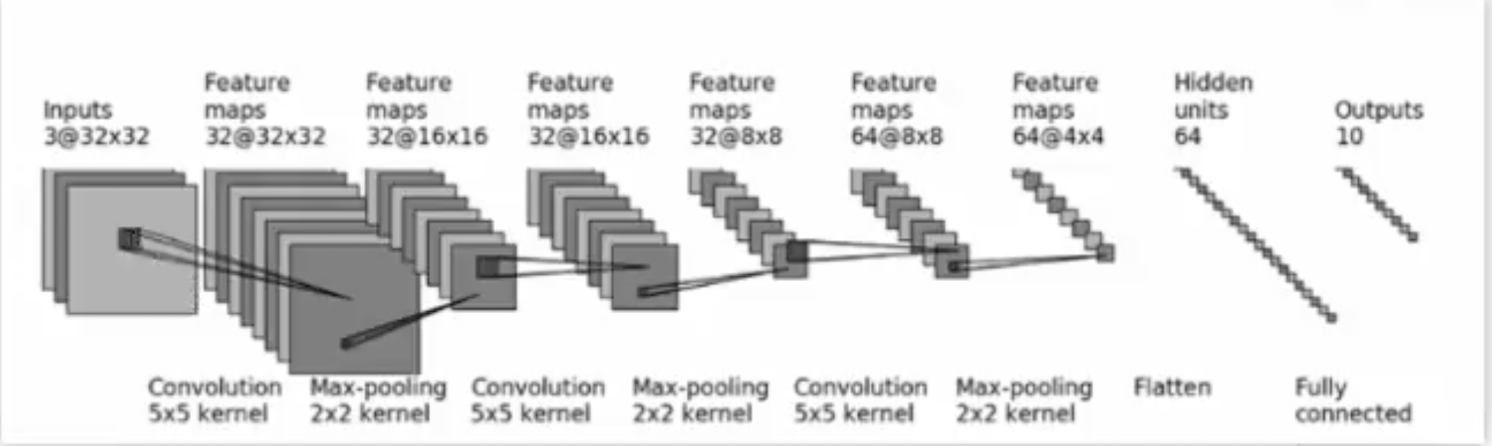

In [56]:
from torch import nn
import torch

# 1.construct network
class Mynetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Conv2d(3,32,5,1,2),nn.MaxPool2d(2),
                                   nn.Conv2d(32,32,5,1,2), nn.MaxPool2d(2),
                                   nn.Conv2d(32,64,5,1,2),nn.MaxPool2d(2),
                                   nn.Flatten(), nn.Linear(64*4*4,64),nn.Linear(64,10))
    
    def forward(self, data):
        output = self.model(data)
        return output
    

# 2.get the Dataset
input = torch.ones(size=(20,3,32,32),dtype=torch.float32)
y = torch.tensor([[1,2,3,4,5,6,7,8,9,10]],dtype=torch.float32)

# 3.Call the model to get the output
mynn = Mynetwork()
loss_fn = torch.nn.MSELoss(reduction='mean')
learning_rate = 1e-6
optimizer = torch.optim.RMSprop(params=mynn.model.parameters(), lr=learning_rate)
for epoch in range(200):
    print(f"this is epoch {epoch+1}:")
    for data in range(20):
        y_pred = mynn(input)
        # 4.Calculate the loss between real and predicted
        loss = loss_fn(y_pred, y)
        # 7.After one iteration, the gradient should be set to 0
        optimizer.zero_grad()
        # 5.Calculate the gradients
        loss.backward()
        # 6.Use optimizer to upgrade parameters
        optimizer.step()

        if data % 5==0:
            print(loss)

print(f"The final outcome is {y_pred}")

this is epoch 1:
tensor(38.6991, grad_fn=<MseLossBackward0>)
tensor(38.5745, grad_fn=<MseLossBackward0>)
tensor(38.5036, grad_fn=<MseLossBackward0>)
tensor(38.4469, grad_fn=<MseLossBackward0>)
this is epoch 2:
tensor(38.3976, grad_fn=<MseLossBackward0>)
tensor(38.3527, grad_fn=<MseLossBackward0>)
tensor(38.3110, grad_fn=<MseLossBackward0>)
tensor(38.2715, grad_fn=<MseLossBackward0>)
this is epoch 3:
tensor(38.2336, grad_fn=<MseLossBackward0>)
tensor(38.1971, grad_fn=<MseLossBackward0>)
tensor(38.1615, grad_fn=<MseLossBackward0>)
tensor(38.1268, grad_fn=<MseLossBackward0>)
this is epoch 4:
tensor(38.0926, grad_fn=<MseLossBackward0>)
tensor(38.0590, grad_fn=<MseLossBackward0>)
tensor(38.0258, grad_fn=<MseLossBackward0>)
tensor(37.9930, grad_fn=<MseLossBackward0>)
this is epoch 5:
tensor(37.9603, grad_fn=<MseLossBackward0>)
tensor(37.9278, grad_fn=<MseLossBackward0>)
tensor(37.8953, grad_fn=<MseLossBackward0>)
tensor(37.8630, grad_fn=<MseLossBackward0>)
this is epoch 6:
tensor(37.8307, gr